In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import random
import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as plticker


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

import keras_tuner as kt
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Activation, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LSTM, TimeDistributed, RepeatVector, Bidirectional, GRU, SimpleRNN, ReLU, GlobalAveragePooling1D, Softmax, LeakyReLU, PReLU, ELU, ThresholdedReLU, AveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Add, Multiply, Subtract, Maximum, Minimum, Average, Maximum, Dot, Lambda, Reshape, Permute, Embedding, GaussianNoise, GaussianDropout, AlphaDropout, SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, ActivityRegularization, Masking, Dropout, BatchNormalization, LayerNormalization, UpSampling1D, UpSampling2D, UpSampling3D, ZeroPadding1D, ZeroPadding2D, ZeroPadding3D, Cropping1D, Cropping2D, Cropping3D, Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose, SeparableConv1D, SeparableConv2D, DepthwiseConv2D, MaxPooling2D, MaxPooling3D, AveragePooling2D, AveragePooling3D, GlobalMaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling3D, GlobalAveragePooling3D, LocallyConnected1D, LocallyConnected2D, RNN, SimpleRNN, GRU, LSTM, ConvLSTM2D, CuDNNGRU, CuDNNLSTM, Bidirectional, TimeDistributed, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose, SeparableConv1D, SeparableConv2D, DepthwiseConv2D, MaxPooling1D, MaxPooling2D, MaxPooling3D, AveragePooling1D, AveragePooling2D, AveragePooling3D, GlobalMaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling3D, GlobalAveragePooling3D, LocallyConnected1D, LocallyConnected2D, Add, Subtract, Multiply, Average, Maximum, Minimum, Concatenate, Dot, Multiply, Lambda, Reshape, Permute, Embedding, GaussianNoise, GaussianDropout, AlphaDropout, SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, ActivityRegularization, Masking, Dropout, BatchNormalization, LayerNormalization, UpSampling1D, UpSampling2D, UpSampling3D, ZeroPadding1D, ZeroPadding2D
from keras.layers import LSTM
from keras.layers import Dropout, TimeDistributed
from keras.losses import Huber, LogCosh
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# np.set_printoptions(threshold=np.inf)
from keras.utils.vis_utils import plot_model
from keras.utils import set_random_seed
from keras.utils import to_categorical

In [138]:
data = pd.read_csv("./datasets/data.csv",header=None)

In [140]:
remove_list = ["AMPBTC"] # Filter out AMPBTC because data sequences are different to the rest                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
remove = []
for coin in remove_list:
    remove += data.index[data[0] == coin ].tolist()

data2=np.delete(data.values,remove,0).transpose()
data2=np.delete(data2,0,0)

In [141]:
def classify_data(max_price_amplitudes):
    num_classes = 2
    classes = []
    report = np.zeros(num_classes)
    for i in range(len(max_price_amplitudes)):
        if max_price_amplitudes[i]<5:
            classes.append(0)
            
            report[0]+=1
        else:
            classes.append(1)
            
            report[1]+=1
    return np.asarray(classes).astype("float32"), num_classes, report
    

activation ReLu -> Softmax
0.89

In [142]:
#configurations
epochs=1000
batch_size=10
divide_factor=1.15
train_size_percent = 0.8
validation_split = 0.2
points = 50

In [143]:
max_price_amplitude = np.zeros([len(data2)]) # in percentage

# get max price amplitudes and normalize data into data_normalized
data_normalized = np.zeros(np.shape(data2))
for i in range(np.shape(data2)[1]):  
    max_price_amplitude = np.c_[max_price_amplitude, np.ones([len(data2),1])*(max(data2[:,i])/data2[0,i]*100-100)]
    for j in range(len(data2)):
        data_normalized[j,i] = data2[j,i]/(divide_factor*data2[0,i])
max_price_amplitude = max_price_amplitude[:,1:].reshape([-1,np.shape(data2)[1],1])

[1091.  454.]


([<matplotlib.patches.Wedge at 0x29a595c9510>,
 [Text(-0.6636328351350027, 0.8772636206583961, '0-5%'),
  Text(0.663632835135003, -0.8772636206583959, '>5%')],
 [Text(-0.3619815464372742, 0.4785074294500342, '70.6%'),
  Text(0.3619815464372743, -0.4785074294500341, '29.4%')])

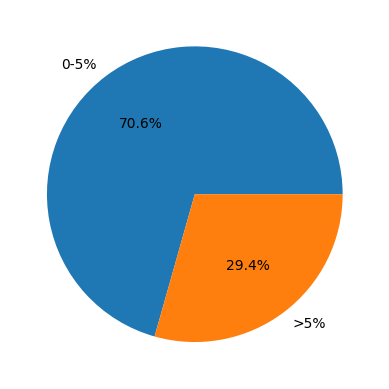

In [144]:
classes, num_classes, class_count = classify_data(max_price_amplitude[0,:])
print(class_count)
labels = '0-5%','>5%'

fig, ax = plt.subplots()
ax.pie(class_count, labels=labels, autopct='%1.1f%%')

In [146]:
#create datasets
def create_dataset(data,points):    
    return data[0:points,:]


train_size = int(np.shape(data_normalized)[1] * train_size_percent)
test_size = np.shape(data_normalized)[1] - train_size


trainX = create_dataset(data_normalized[:,:train_size],points).transpose()
trainY = to_categorical(classes[:train_size],num_classes)

testX = create_dataset(data_normalized[:,train_size:],points).transpose()
testY = to_categorical(classes[train_size:],num_classes)

print('Training dataset length ', train_size)
print('Testing dataset length ', test_size)

Training dataset length  1236
Testing dataset length  309


In [187]:
# Get random seed or set one
seed = 816148
#seed = int(random.random()*1e6)
print(seed)
set_random_seed(
    seed
)

""" #For using with keras tuner
def make_model2(hp):
    input_shape = (points,1)
    model = Sequential()
    model.add(Conv1D(hp.Int('input_filter',min_value=8,max_value=128,step=8), hp.Int('input_kernel_size',min_value=1,max_value=10,step=1), padding="same", input_shape=(points,1)))
    dropout_rate = hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.05)
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(ReLU())
    for i in range(hp.Int('n_layers', 1, 6)):
        model.add(Conv1D(hp.Int(f"layer_{i}_filter",min_value=8,max_value=128,step=8), hp.Int(f"layer_{i}_kernel_size",min_value=1,max_value=10,step=1), padding="same"))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())
        model.add(ReLU())

    model.add(GlobalAveragePooling1D())

    model.add(Dense(num_classes, activation=hp.Choice('output_activation',values=['softmax', 'relu','sigmoid'])))
    model.compile(loss="categorical_crossentropy",    metrics=["accuracy"], optimizer=hp.Choice('optimizer',values=['adam', 'sgd']))
    return model
"""
def make_model():
    
    model = Sequential()
    model.add(Conv1D(104,6, padding="same", input_shape=(points,1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    n_layers = 3
    filter_sizes = [120,48,104,120,80,120,48,104,120,80]
    kernels = [8,5,5,2,9,8,5,5,2,9]
    for i in range(n_layers):
        model.add(Conv1D(filter_sizes[i], kernels[i], padding="same"))
        model.add(BatchNormalization())
        model.add(ReLU())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(num_classes, 'softmax'))
    model.compile(loss="categorical_crossentropy",    metrics=["accuracy"], optimizer='sgd')
    return model

callbacks = [
    ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=80, min_lr=0.00005
    ),
    EarlyStopping(monitor="val_loss", patience=400, verbose=1,restore_best_weights=True),
]
model = make_model()
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]


history= model.fit(trainX,
    trainY,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=validation_split,
    verbose=1,)

816148
(None, 50, 1) <dtype: 'float32'>
(None, 2) <dtype: 'float32'>
conv1d_66 (None, 50, 1) float32
batch_normalization_66 (None, 50, 104) float32
re_lu_58 (None, 50, 104) float32
conv1d_67 (None, 50, 104) float32
batch_normalization_67 (None, 50, 120) float32
re_lu_59 (None, 50, 120) float32
conv1d_68 (None, 50, 120) float32
batch_normalization_68 (None, 50, 48) float32
re_lu_60 (None, 50, 48) float32
conv1d_69 (None, 50, 48) float32
batch_normalization_69 (None, 50, 104) float32
re_lu_61 (None, 50, 104) float32
global_average_pooling1d_19 (None, 50, 104) float32
dense_19 (None, 104) float32
Epoch 1/1000
99/99 [==============================] - 8s 30ms/step - loss: 0.5053 - accuracy: 0.7682 - val_loss: 0.6508 - val_accuracy: 0.7419 - lr: 0.0100
Epoch 2/1000
99/99 [==============================] - 2s 25ms/step - loss: 0.4956 - accuracy: 0.7733 - val_loss: 0.5666 - val_accuracy: 0.7419 - lr: 0.0100
Epoch 3/1000
99/99 [==============================] - 2s 23ms/step - loss: 0.4898 - acc

In [190]:
predicted = model.predict(testX)
test_loss, test_acc = model.evaluate(testX, testY)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

10/10 [==============================] - 0s 7ms/step - loss: 0.3256 - accuracy: 0.8511
Test accuracy 0.8511326909065247
Test loss 0.32558634877204895


In [191]:
print(classification_report(np.argmax(testY, axis=1), np.argmax(predicted, axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       243
           1       0.69      0.55      0.61        66

    accuracy                           0.85       309
   macro avg       0.79      0.74      0.76       309
weighted avg       0.84      0.85      0.84       309



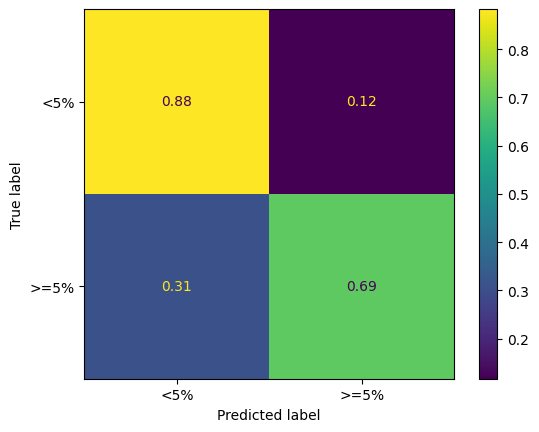

In [192]:
matrix = confusion_matrix(np.argmax(predicted, axis=1), np.argmax(testY, axis=1),normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['<5%', '>=5%'])

cm_display.plot()
plt.show()

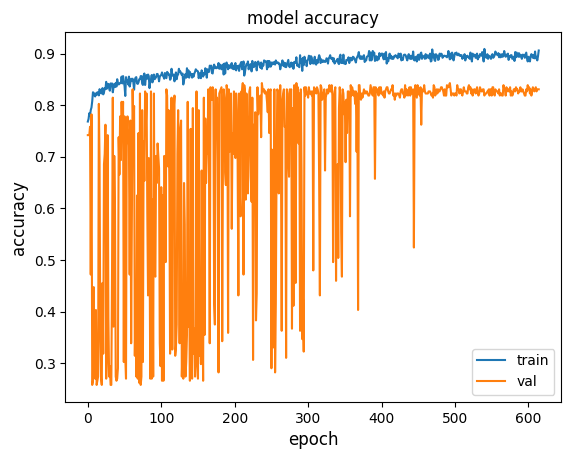

In [194]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [193]:
import winsound
duration = 3000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)